# Machine learning win percentage

As people watch a football game, they have some understanding of which team is likely to win the game. There are several aspects to that kind of internal calculation; a person will weigh the whole game situation in order to make the best guess about the outcome of the game. She will take into account the score, how much time is remaining in the game, which team has the ball. To get even more precise, she can consider down and distance. In addition, she will have her own idea of which team is the superior side based on their previous games.

That whole calculation is pretty instantaneous for someone who has watched any amount of football before. And with practice, someone can get better at making accurate predictions. The same principle should hold for a computer, except that algorithms are typically better at estimating probabilities than people are.

Win percentage (WP) is an example of an "advanced metric" that's pretty simple to understand. Given a particular game situation, the win percentage is the likelihood that one team will go on to win the game. Various researchers and analysis outlets have created their own models for calculating win percentage over the past decade or so. In this notebook, I compare a couple of different machine learning techniques as they are applied to the problem of calculating the win percentage for NFL football games.

## The competing methods

I am going to try and use neural network and random forest algorithms. These are both implemented in the python package sci-kit learn. Part of my motivation for undertaking this project is to learn the methods, so developing the best possible model is not of the highest priority. As I mentioned before, several well-respected methods already exist, which gives me a good basis for comparison.

#### Random Forest

At its heart, the random forest algorithm is a decision tree. What that means is that given the information for a game scenario -- score, time remaining, possession, down, distance, etc. -- the algorithm traverses a tree of decision points, eventually returning a decision on whether the team with the ball will win the game.

One of the main problems with a decision tree is that they tend to overfit the data set they are given. In order to rectify that problem, the random forest consists of many different decision trees that are fit to different portions of the training set. The final prediction from the random forest is an average over the predictions from each individual decision tree.

#### Neural Network

Neural networks were originally modeled from the structure of neurons in the brain, allowing for the multitude of connections that form in the brain. Since the original idea, there have been several different implementations of neural networks, but the most basic idea is a fancier version of a regression model. Where a regression model assigns a weight to each of the input variables and sums them to produce an output, a neural network takes a bunch of individual nodes that can activate depending on the signals that they get from their inputs.

The interpretation of a neural network is less clear than that of a decision tree, but neural networks are now famous for their success in solving a wide range of problems, from natural language processing to image recognition to beating the Go world champion. Predicting which team will win a football game seems simple in comparison.

## The dataset

I will be using a dataset of detailed play-by-play data from 1996 to 2015. I scraped the data from Pro Football Reference and previously wrote about how I put that dataset together. One of the potential benefits of the PFR dataset for this particular application is that PFR includes a win percentage with each play, giving us a professionally-calibrated comparison for each data point.

## Preparing the data

In order to train either a random forest or neural network model, I still need to prepare the dataset. First, import some packages that will be used and load the dataset from a file.

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
allplays_df = pd.read_csv("plays1996-2015.csv")
allplays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857421 entries, 0 to 857420
Data columns (total 25 columns):
Unnamed: 0          857421 non-null int64
quarter             857421 non-null object
qtr_time_remain     716229 non-null object
down                780220 non-null float64
yds_to_go           780220 non-null float64
location            832968 non-null object
detail              856743 non-null object
away_score_after    857421 non-null int64
home_score_after    857421 non-null int64
exp_pts_before      857421 non-null float64
exp_pts_after       857421 non-null float64
home_wp             857420 non-null float64
players_involved    854653 non-null object
scoring_play        857421 non-null int64
change_of_poss      857421 non-null float64
home_team           857421 non-null object
away_team           857421 non-null object
possession          857421 non-null object
winner              857421 non-null object
home_score          857421 non-null float64
away_score          857421

This information describes the database that was just loaded from the .csv file. It contains 23 columns of information (some of which I doctored when I acquired the data) and 864,540 rows, each corresponding to one NFL play between 1996 and 2016. Not all of this information will be useful for estimating which team is likely to win the game, so choose a subset to keep track of now.

Start by dropping plays that don't have an entry for qtr_time_remaining

In [3]:
allplays_df = allplays_df[ pd.notnull(allplays_df['qtr_time_remain']) ]
allplays_df.shape

(716229, 25)

Now choose a subset of the columns to keep, for simplicity's sake. For the time being, I have no metric for judging a team's strength, so I will treat all teams as equal. This is not a particularly good approximation to make, but we'll see how well the algorithms perform without that additional parameter.

From the database, I extract the game situation based on each team's score, how many seconds have been played in the game, which team has the ball, the offense's field position, as well as the down and distance. I also keep track of which team ended up winning the game as well as PFR's measurement of the offense's win percentage. I keep these last two columns in order to train the model and compare its results with those of PFR, respectively.

In [4]:
cols = [
    'home_score', 'away_score', 'secs_played', 'possession', 
    'off_fieldpos', 'down', 'yds_to_go', 
    'game_url', 'home_wp', 'winner']
#allplays_df = allplays_df[ cols ]
allplays_df[cols].head(5)

,home_score,away_score,secs_played,possession,off_fieldpos,down,yds_to_go,game_url,home_wp,winner
0,0.0,0.0,0,away,-20,NaN,NaN,199609010car,45.1,home
11,7.0,0.0,304,home,-20,NaN,NaN,199609010car,62.5,home
20,7.0,0.0,527,home,-47,1.0,10.0,199609010car,62.2,home
24,7.0,0.0,618,away,2,1.0,10.0,199609010car,56.0,home
31,7.0,3.0,759,away,-20,NaN,NaN,199609010car,56.4,home


For simplicity's sake, I'll only keep track of plays where the offense starts with the ball on downs 1-4, dropping kickoffs and extra points.

In [5]:
# Fill in 0 for downs and distance if not listed
allplays_df['down'].fillna(0, inplace=True)
allplays_df['yds_to_go'].fillna(0, inplace=True)

# Drop plays with down zero
allplays_df = allplays_df[ allplays_df['down'] > 0 ]

allplays_df[cols].head(5)

,home_score,away_score,secs_played,possession,off_fieldpos,down,yds_to_go,game_url,home_wp,winner
20,7.0,0.0,527,home,-47,1.0,10.0,199609010car,62.2,home
24,7.0,0.0,618,away,2,1.0,10.0,199609010car,56.0,home
33,7.0,3.0,771,away,31,1.0,10.0,199609010car,43.0,home
37,7.0,3.0,830,home,-26,1.0,10.0,199609010car,57.0,home
40,7.0,3.0,1730,home,26,1.0,10.0,199609010car,71.8,home


I'll make a couple of different columns to input into any model that should make sense based on the column titles. So I'll rewrite a few aspects of the game situation from the offense's perspective. As a note on the code, this may be an inefficient way to perform these functions since the way this is written, each row in the dataframe must be converted into a series before they can be operated on.

In [6]:
# Make a column for whether or not the offense is home
func = lambda poss: 1 if "home" in poss else 0
allplays_df['offense_is_home'] = allplays_df['possession'].apply(func)

# Add a column for the total score
def tot_pts(play):
    return play.home_score + play.away_score
allplays_df['total_score'] = allplays_df.apply(
    lambda row: tot_pts(row), axis=1 )

# Calculate score differential for the offense
def differential(play):
    if "home" in play.possession:
        return play.home_score - play.away_score
    else:
        return play.away_score - play.home_score
allplays_df['score_diff'] = allplays_df.apply( 
    lambda row: differential(row), axis=1 )

# Rewrite winner from ofense's perspective
def off_win(play):
    if "home" in play.possession and "home" in play.winner:
        return 1
    elif "home" in play.possession and "away" in play.winner:
        return 0
    elif "away" in play.possession and "away" in play.winner:
        return 1
    else:
        return 0
allplays_df['offense_wins'] = allplays_df.apply(
    lambda row: off_win(row), axis=1 )

One of the academic papers I found (from Lock and Nettleton 2014) calculated a win percentage, also with a random forest algorithm. One of the interesting features of their model is a particular column that combines the score differential with the time remaining in the game. I will do something similar.

In [7]:
# Add a column for adjusted score
def adjusted_score(play):
    if play.secs_played < 3600:
        return play.score_diff / math.sqrt( 3600-play.secs_played + 1 )
    else: # Game is in overtime, score differential is zero
        return 0
allplays_df['adj_score'] = allplays_df.apply(
    lambda row: adjusted_score(row), axis=1 )

Any predictive model worth its salt should be able to account for team strength when making predictions. There are a bunch of different ways to try and do that, among which is FiveThirtyEight's ELO ratings, which assign each team a score based on their performance in previous games. Short of trying to scrape that data or develop another model from scratch, options are much more limited.

Another way of measuring team strength is to look at gambling markets. The Vegas line isn't perfect, but it does give a pretty good indication of which team is favored to win the game. If you're unfamiliar with how a Vegas line works, I'll give a brief example. For example, when Cincinnati played at San Francisco in week 15 of the 2015 season, the Vegas line ended up as "Cincinnati 5.5," meaning that Cincinnati was a 5.5-point underdog. If instead the line were "Cincinnati -3" that would instead make Cincinnati 3 point favorites.

Conveniently, I included the spread for each game when I grabbed my data set, so I just need to translate the spread into expectations for the offensive team.

In [8]:
# dictionary for short versions of team names
short_version = {
    'Atlanta Falcons':'ATL', 'New Orleans Saints':'NOR', 
    'Carolina Panthers':'CAR', 'Tampa Bay Buccaneers':'TAM',
    'New York Giants':'NYG', 'Dallas Cowboys':'DAL',
    'Philadelphia Eagles':'PHI', 'Washington Redskins':'WAS',
    'Minnesota Vikings':'MIN', 'Green Bay Packers':'GNB',
    'Detroit Lions':'DET', 'Chicago Bears':'CHI',
    'Seattle Seahawks':'SEA', 'San Francisco 49ers':'SFO',
    'Arizona Cardinals':'ARI', 'Los Angeles Rams':'LAR', 'St. Louis Rams':'STL',
    'Pittsburgh Steelers':'PIT', 'Cleveland Browns':'CLE',
    'Cincinnati Bengals':'CIN', 'Baltimore Ravens':'BAL',
    'Buffalo Bills':'BUF', 'New York Jets':'NYJ',
    'Miami Dolphins':'MIA', 'New England Patriots':'NWE',
    'Tennessee Titans':'TEN', 'Jacksonville Jaguars':'JAX', 
    'Houston Oilers':'HOU', 'Tennessee Oilers':'TEN',
    'Indianapolis Colts':'IND', 'Houston Texans':'HOU',
    'Denver Broncos':'DEN', 'Oakland Raiders':'OAK',
    'San Diego Chargers':'SDG', 'Kansas City Chiefs':'KAN'
}

In [9]:
# get the spread for the offense
def off_spread(play):
    # check for a tossup
    if "Pick" in play.spread:
        return 0
    
    # Split the spread into strings
    sprd = play.spread.split()
    number = float(sprd[len(sprd)-1])
    direction = " ".join([str(a) for a in sprd[:-1]]) # Drop the last element in list
    
    # Get short version of team name in spread to compare w/ home team
    team1 = short_version[direction]
    if team1 == play.home_team:
        if play.offense_is_home:
            # offense is favored by number
            return number
        else:
            return -number
    elif team1 == play.away_team:
        if play.offense_is_home:
            # defense is favored by number
            return -number
        else:
            return number
        
allplays_df['off_favored_by'] = allplays_df.apply(
    lambda row: off_spread(row), axis=1 )

allplays_df[['spread', 'home_team', 'offense_is_home', 'off_favored_by']].head(5)

,spread,home_team,offense_is_home,off_favored_by
20,Atlanta Falcons 3.0,CAR,1,-3.0
24,Atlanta Falcons 3.0,CAR,0,3.0
33,Atlanta Falcons 3.0,CAR,0,3.0
37,Atlanta Falcons 3.0,CAR,1,-3.0
40,Atlanta Falcons 3.0,CAR,1,-3.0


And finally choose the columns that will be used as input for the model and a separate column for the results.

In [10]:
model_cols = ['off_favored_by',
              'score_diff', 'adj_score', 'total_score', 'secs_played', 
              'offense_is_home', 'off_fieldpos', 'down', 'yds_to_go']
X = allplays_df[model_cols]
y = allplays_df['offense_wins']

Separate our input data into a training and test set. For right now I'll use 50% of the data (still over 340 thousand plays) to train the model.

In [11]:
msk = np.random.rand(len(X)) < 0.5
X_train = X[msk]
X_test = X[~msk]
y_train = y[msk]
y_test = y[~msk]
print(len(y_train))
print(len(y_test))

343504
342883


## Make a random forest classifier

As I mentioned, the random forest classifier is implemented in sci-kit learn. Load it up and let's get started.

In [12]:
from sklearn.ensemble import RandomForestClassifier

I'm not going to mess with the default settings for either of these two algorithms too much. I want to use this notebook more as a way to compare the results of the algorithms more than an exercise in maximizing their performance. 

That said, I do want to make sure that I have a bunch of different random trees in my forest. Football games make for a lot of noise in the data set, and it would be counter-productive for the decision trees to overfit in an effort to reproduce the noise. So, I'll make a forest of 100 decision trees, each of which can fit it's dataset pretty well. As can be seen from my output, the fitting process can take a little while. Keep in mind that the computer is dealing with 300 thousand data points; the details are all hidden, but this is a non-trivial operation.

In [13]:
# Train the random forest
forest_model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=10,
#    min_samples_leaf=5,
    max_features=None,
    verbose=1
    )
forest_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=1, warm_start=False)

After fitting the model, take a quick look at how it performs on the test set. The model has a nice built in function for doing that, so take advantage.

In [14]:
# Score the model
forest_model.score(X_test, y_test)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.9s finished


0.80830779012082843

I'll write the model's predictions directly into the dataframe holding the plays so that I can easily compare the results from different models. Eventually.

In [15]:
# Write the model's predictions into our dataframe
allplays_df['forest_off_WP'] = [
    i[1] for i in forest_model.predict_proba(allplays_df[model_cols])
    ]
allplays_df['forest_off_WP'].head(5)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.0s finished


20    0.542193
24    0.137690
33    0.274242
37    0.800298
40    0.747827
Name: forest_off_WP, dtype: float64

## Evaluating the model

In addition to the quick score I looked at above, I would like to show how the model behaves in a couple of ways. 
1. In general, I want to make sure that when the model returns a win percentage of .75 that the offense will win 75% of the time.
2. I want to be able to look at how the win percentage changes over the course of a single game so that we can compare the evolution of the game situation against the model's predictions.

First up is to look at the model in general. I'll make a histogram showing how many of the teams predicted to win with a given percentage actually go on to win the game. I'll write this as a function so that it can be re-used for the other model without repeating the code.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_histogram(df, col):
    x_vals = []
    y_vals = []
    num_bins = 50
    
    # Make bins for predicted win_percentage
    for i in range(num_bins):
        dx = 1/(num_bins)
        x = (i+0.5)*dx
        x_vals.append(x)
        
        subdf = df[
            (df[col] >= i*dx) &
            (df[col] < (i+1)*dx)
            ]
        y = subdf['offense_wins'].mean()
        y_vals.append( y )
    
    # Define values for a perfect fit
    perf_x = [x/num_bins for x in range(num_bins+1)]
    perf_y = perf_x
    
    # Make the plot
    plt.scatter(x_vals, y_vals)
    plt.plot(perf_x, perf_y)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Predicted Win%')
    plt.ylabel('Actual Win%')
    plt.show()

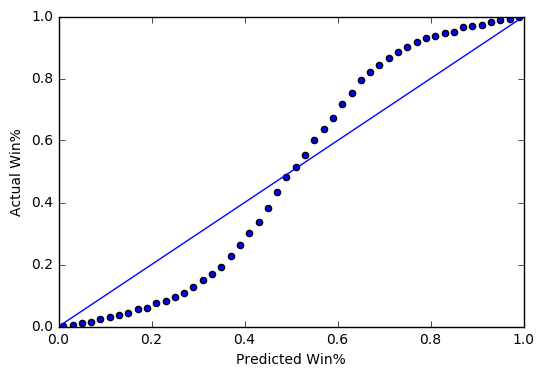

In [17]:
show_histogram( allplays_df, 'forest_off_WP')

The closer this plot gets to the blue line, the better the model performs, in general. In this case, we have some serial deviation from the ideal curve. The model seems to over-estimate the chances of teams that have low WPs and under-estimates the chances of teams with high WPs.

Next I'll make a function to plot the WP over the course of a single game.

In [18]:
# Make a list of all game urls
games = allplays_df['game_url'].unique()
print(games[:5])

['199609010car' '199609080atl' '199609220atl' '199609290sfo' '199610060det']


In [19]:
def plot_game(df, model_WP, game_url):
    game_df = df[ df['game_url'].str.contains(game_url) ]
    home = game_df['home_team'].values[0]
    away = game_df['away_team'].values[0]
    
    model_x = game_df['secs_played']
    
    # Get win pct for home team rather than offense
    win_pct = game_df[model_WP].values
    off_is_home = game_df['offense_is_home'].values
    model_y = []
    for i, pct in enumerate(win_pct):
        if off_is_home[i] == 1:
            model_y.append(pct)
        else:
            model_y.append(1-pct)
            
    # Make the plot
    plt.plot(model_x, model_y)
    plt.axis([0, max(model_x), 0, 1])
    plt.xlabel('Seconds played')
    plt.ylabel('Home win%')
    xpts = [900, 1800, 2700, 3600]
    xlabels = ['Q2', 'HT', 'Q4', 'EOR']
    ypts = [0, 0.5, 1]
    ylabels = [away, "50%", home]
    plt.yticks(ypts, ylabels)
    plt.xticks(xpts, xlabels)
    for i in xpts:
        plt.axvline(x=i, color='black', alpha=0.5)
    for i in [0.25, 0.5, 0.75]:
        plt.axhline(y=i, color='black', alpha=0.5, ls=':')
        
    plt.show()

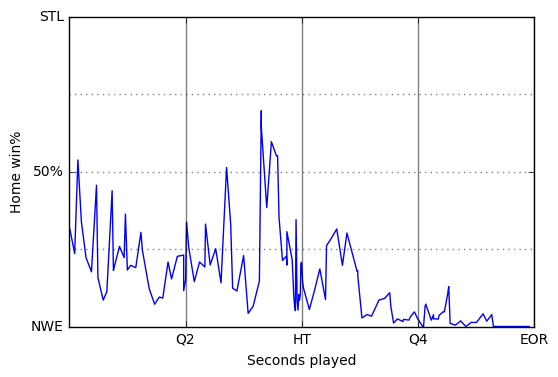

In [20]:
plot_game(allplays_df, 'forest_off_WP', games[2222])

You might be thinking that this looks a bit funky. That's true, the projected WP swings wildly (and unreasonably) back and forth for the whole game. That's not exactly realistic, and I'll talk more about it after I've trained a neural network.

## Make a neural network classifier

As I mentioned at the beginning of the post, I'll be using the neural network implemented in scikit-learn. I'll go through the setup pretty briskly and talk a bit more about the results instead.

For neural networks, having normalized data is pretty important for the algorithm to weigh different inputs equivalently (otherwise gradients used to minimize the cost function will be more heavily impacted by inputs with larger ranges of values), so I'll make sure to scale the input values before feeding them into the model.

In [21]:
# Try scaling inputs with sklearn preprocessing
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
neural_X_train = robust_scaler.fit_transform(X_train)
neural_X_test = robust_scaler.transform(X_test)

In [22]:
# MLP stands for multilayer perceptron
from sklearn.neural_network import MLPClassifier

And now train the model. For this writeup, I've created a neural network with three "hidden" levels of 25 nodes each. The size of the network is something that would need to be tuned in order to maximize performance, as well as hyper-parameters like learning rate and batch size but this will do for now. My main concern here is that I have multiple hidden layers so that the model can include a great deal of complexity. Also, consider that training this model requires minimizing a cost function with respect to each of the inputs to every node in the network. That makes for a huge number of parameters, so be patient with the computer; training this neural network is a lot of work.

In [23]:
neuralnet_model = MLPClassifier(
    hidden_layer_sizes=(25, 25, 25),
#    learning_rate_init=0.005,
    batch_size=250,
    tol=1e-5,
    verbose=True
    )
neuralnet_model.fit(neural_X_train, y_train)

Iteration 1, loss = 0.49578945
Iteration 2, loss = 0.48679865
Iteration 3, loss = 0.48593056
Iteration 4, loss = 0.48544804
Iteration 5, loss = 0.48502578
Iteration 6, loss = 0.48469319
Iteration 7, loss = 0.48446824
Iteration 8, loss = 0.48429376
Iteration 9, loss = 0.48406270
Iteration 10, loss = 0.48394113
Iteration 11, loss = 0.48380600
Iteration 12, loss = 0.48357562
Iteration 13, loss = 0.48350052
Iteration 14, loss = 0.48330249
Iteration 15, loss = 0.48323027
Iteration 16, loss = 0.48316059
Iteration 17, loss = 0.48304485
Iteration 18, loss = 0.48296909
Iteration 19, loss = 0.48291347
Iteration 20, loss = 0.48280718
Iteration 21, loss = 0.48271721
Iteration 22, loss = 0.48260256
Iteration 23, loss = 0.48250594
Iteration 24, loss = 0.48245652
Iteration 25, loss = 0.48238166
Iteration 26, loss = 0.48223735
Iteration 27, loss = 0.48220693
Iteration 28, loss = 0.48211868
Iteration 29, loss = 0.48205052
Iteration 30, loss = 0.48192129
Iteration 31, loss = 0.48190547
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size=250, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(25, 25, 25), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=1e-05, validation_fraction=0.1,
       verbose=True, warm_start=False)

Like with the other algorithm, do a quick test to see how the model performs on the test set.

In [24]:
neuralnet_model.score(neural_X_test, y_test)

0.74845355412779291

That's a bit lower than the random forest scored, but still way better than guessing at random. Like I did before, I'll add the prediction for each play to the dataframe.

In [25]:
allplays_df['neuralnet_off_WP'] = [
    i[1] for i in neuralnet_model.predict_proba( 
        robust_scaler.transform( allplays_df[model_cols] )
        )
    ]
allplays_df['neuralnet_off_WP'].head(5)

20    0.757409
24    0.308711
33    0.405286
37    0.607292
40    0.697338
Name: neuralnet_off_WP, dtype: float64

Let's see how well the network performs by looking at the same histogram as we used above and tracking the win percentage over the course of the same game.

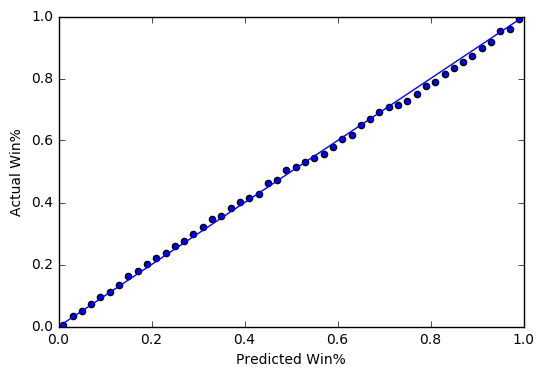

In [26]:
show_histogram( allplays_df, 'neuralnet_off_WP')

Despite the lower success score on the test set, this histogram makes the model look very good, almost perfectly fitting the ideal curve. That means that when the model predicts that the home team has a 60% chance of winning the game, they go on to win the game 60% of the time. That's definitely what the model is supposed to do.

Now take a look at what this model thinks about the same game I looked at above.

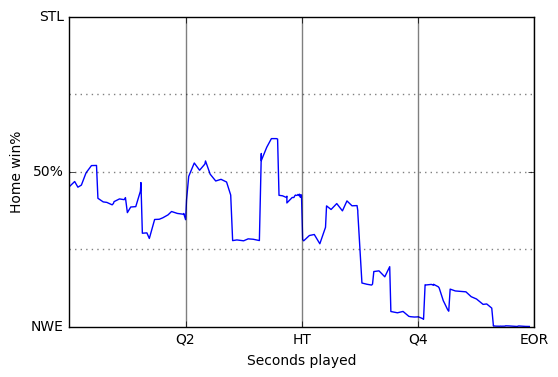

In [27]:
plot_game(allplays_df, 'neuralnet_off_WP', games[2222])

The general shape of this plot is similar to that produced by the random forest. There are still some big jumps in the WP, but going from one play to the next, the whole product looks a lot smoother. However, to really compare the models, we'll want to look at things side-by-side.

## Comparing the models

To look at the models side-by-side, of course, requires a bit more code. In addition to the results from the random forest and the neural network, I'll also add a plot with PFR's WP.

In [28]:
def combo_plot(game_url):
    print(game_url)
    # Set up 3 plots to fill in for the 2 models and PFR for comparison
    f, axarr = plt.subplots(3, sharex=True, sharey=True)
    
    # Pull the plays for this game
    game_df = allplays_df[ allplays_df['game_url'].str.contains(game_url) ]
    home = game_df['home_team'].values[0]
    away = game_df['away_team'].values[0]
    model_x = game_df['secs_played']
    
    # Print which team wins the game
    subdf = game_df[['offense_wins', 'offense_is_home']]
    play1 = subdf[:1]
    if play1.values[0,0] > 0 and play1.values[0,1] > 0:
        print(home+" wins")
    elif play1.values[0,0] == 0 and play1.values[0,1] == 0:
        print(home+" wins")
    elif sum(x for x in game_df['offense_wins'].values) == 0:
        print("game was a TIE")
    else:
        print(away+" wins")
    
    # For my models, get win pct for home team rather than offense
    for i, model_WP in enumerate(['forest_off_WP', 'neuralnet_off_WP']):
        win_pct = game_df[model_WP].values
        off_is_home = game_df['offense_is_home'].values
        model_y = []
        for j, pct in enumerate(win_pct):
            if off_is_home[j] == 1:
                model_y.append(pct)
            else:
                model_y.append(1-pct)
                
        # Set the WP from this model to the Y values for one of the plots
        axarr[i].plot(model_x,model_y)
    
    # Plot WP from PFR
    axarr[2].plot(model_x, game_df['home_wp']/100.0 )
    

    # Put in axes, ticks, etc.
    axarr[0].axis([0, max(model_x), 0, 1])
    xpts = [900, 1800, 2700, 3600]
    xlabels = ['Q2', 'HT', 'Q4', 'EOR']
    ypts = [0, 0.5, 1]
    ylabels = [away, "50%", home]
    plt.setp(axarr, xticks=xpts, xticklabels=xlabels,
             yticks=ypts, yticklabels=ylabels)
    for j in range(3):
        for i in xpts:
            axarr[j].axvline(x=i, color='black', alpha=0.5)
        for i in [0.25, 0.5, 0.75]:
            axarr[j].axhline(y=i, color='black', alpha=0.5, ls=':')
    
    # Set up titles for the 3 plots
    axarr[0].set_ylabel("Forest")
    axarr[1].set_ylabel("Neural Net")
    axarr[2].set_ylabel("PFR")
    
    plt.show()

The first thing I'll use to compare the models is the game that we've already looked at for each model separately. 

200411070ram
NWE wins


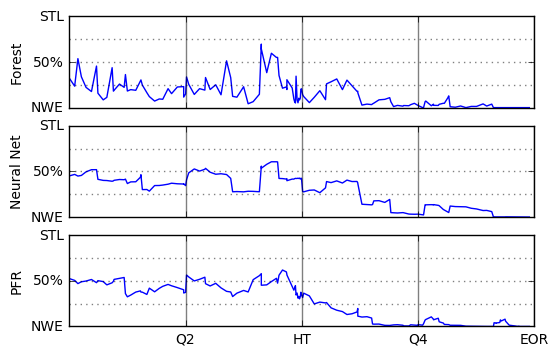

In [29]:
combo_plot(games[2222])

Looking at the plots like this really allows us to highlight the similarities and differences between the models' predictions.

There are some obvious places where the predictions differ, and where different models produce features in the WP that may look different or not exist in the other plots. However, the basic shape of the plot is very similar between the three models, telling a very similar story about the course of the game. When the Patriots went to visit the Rams of St. Louis in 2004, the game looked like a tossup for the whole first half. Then, in the third quarter, the Patriots pulled into what must have been a commanding lead, making victory almost inevitable. Early in the fourth, the Rams rallied a bit, giving themselves a chance to get back in the game. But the comeback was short-lived and the Patriots ended up winning comfortably.

So while the particulars may not be the same, each model captured the overall arc of the game fairly well. Based on this one game, each model looks like a success. But I'll reserve judgment until that holds true for a few more games.

200112230nyg
NYG wins


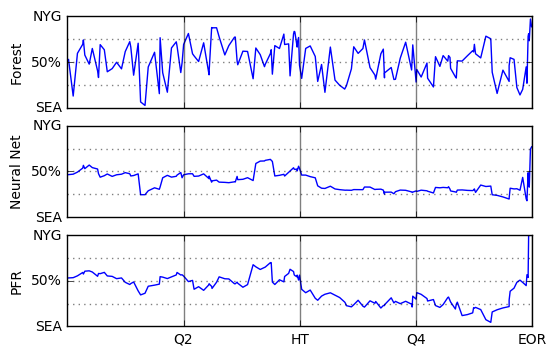

In [30]:
combo_plot( games[1337] )

Look at this 2001 game between the Giants and Seahawks. There plot from the random forest is pretty noisy, but we can see that game was basically a tossup until the fourth quarter. 

The neural net tells a story very similar to the one that PFR's model does, with the game gradually tipping towards the Seahawks until the Giants take the lead with just before the game ends. Looking at the random forest after the other two, we can see the same basic pattern. So that's two pretty good games for the models. Can we make it three?

200911220det
DET wins


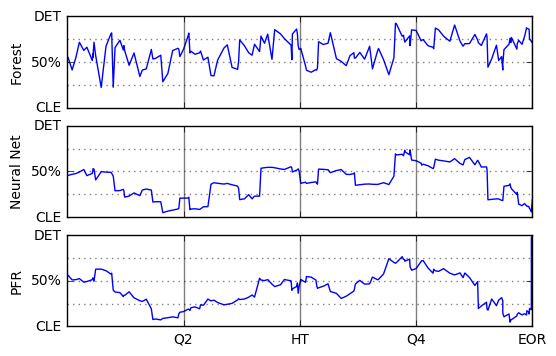

In [31]:
combo_plot( games[3437] )

In this 2009 game between Detroit and Cleveland, something a bit weird happens with the models. Late in the fourth, the PFR and neural net model have the game tilted strongly toward Cleveland, but the random forest has Detroit as more likely to win. Without looking more closely at exactly what the game situation is for this section of the game or investigating the paths through the decision trees, it's hard to say why the difference between the models' predictions is so large.

I'll take a look at one more game.

200809210buf
BUF wins


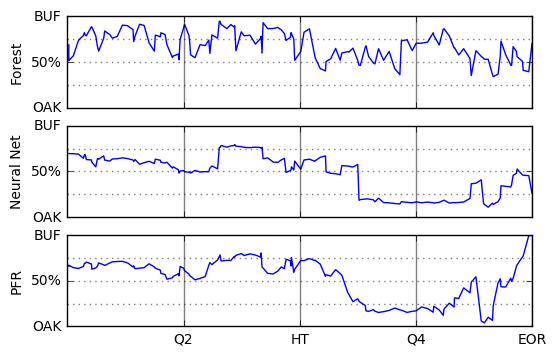

In [32]:
combo_plot( games[3335] )

This game between Buffalo and Oakland looks like another somehwat odd case. It looks like Buffalo is favored coming into the game, and the models basically agree on how the game is going through the first half. But in the third quarter, the models diverge a bit, with the PFR/neural net pair giving the edge to Oakland. But the random forest continues to give a narrow edge to Buffalo. Then, the neural net breaks from PFR's model to give Oakland a chance to come back, along with the random forest.

Again, without investigating the game and models very closely, it's hard to say what's going on here and why. But that's fodder for future investigation.

## TL;DR

I trained two different machine learning algorithms to predict an NFL offense's chance of winning the game based on the game situation that it finds itself in. There are some points of curiosity I'd like to investigate in the future, but for the most part the models perform pretty well, producing results that generally agree with PFR's imperfect but well-tested model. 